In [ ]:
from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langchain_core.messages import SystemMessage
from langchain_core.tools import tool
from langchain_ollama import OllamaEmbeddings
from langchain_qdrant import QdrantVectorStore
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode, create_react_agent, tools_condition
from qdrant_client import QdrantClient

from plum_chatbot.configs.settings import Settings

In [2]:
settings = Settings()

embeddings = OllamaEmbeddings(model="llama3.2", base_url="host.docker.internal")

client = QdrantClient(
    url=settings.QDRANT_URL, api_key=settings.QDRANT_API_KEY, https=True
)

vector_store = QdrantVectorStore(
    client=client,
    collection_name="FAQ",
    embedding=embeddings,
)

/tmp/ipykernel_4062/2161982073.py:5: UserWarning: Api key is used with an insecure connection.
  client = QdrantClient(url=settings.QDRANT_URL, api_key=settings.QDRANT_API_KEY, https=True)


In [ ]:
llm = init_chat_model(
    "llama3.2",
    model_provider="ollama",
    base_url="host.docker.internal",
    temperature=0.3,
)

In [4]:
@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs


tools = ToolNode([retrieve])

In [5]:
# # Step 1: Generate an AIMessage that may include a tool-call to be sent.
# def query_or_respond(state: MessagesState):
#     """Generate tool call for retrieval or respond."""
#     llm_with_tools = llm.bind_tools([retrieve])
#     response = llm_with_tools.invoke(state["messages"])
#     # MessagesState appends messages to state instead of overwriting
#     return {"messages": [response]}


# # Step 2: Execute the retrieval.
# tools = ToolNode([retrieve])


# # Step 3: Generate a response using the retrieved content.
# def generate(state: MessagesState):
#     """Generate answer."""
#     # Get generated ToolMessages
#     recent_tool_messages = []
#     for message in reversed(state["messages"]):
#         if message.type == "tool":
#             recent_tool_messages.append(message)
#         else:
#             break
#     tool_messages = recent_tool_messages[::-1]

#     # Format into prompt
#     docs_content = "\n\n".join(doc.content for doc in tool_messages)
#     system_message_content = (
#         "You are an assistant for question-answering tasks. "
#         "Use the following pieces of retrieved context to answer "
#         "the question. If you don't know the answer, say that you "
#         "don't know. Use three sentences maximum and keep the "
#         "answer concise."
#         "\n\n"
#         f"{docs_content}"
#     )
#     conversation_messages = [
#         message
#         for message in state["messages"]
#         if message.type in ("human", "system")
#         or (message.type == "ai" and not message.tool_calls)
#     ]
#     prompt = [SystemMessage(system_message_content)] + conversation_messages

#     # Run
#     response = llm.invoke(prompt)
#     return {"messages": [response]}

In [6]:
# graph_builder = StateGraph(MessagesState)
# graph_builder.add_node(query_or_respond)
# graph_builder.add_node(tools)
# graph_builder.add_node(generate)

# graph_builder.set_entry_point("query_or_respond")
# graph_builder.add_conditional_edges(
#     "query_or_respond",
#     tools_condition,
#     {END: END, "tools": "tools"},
# )
# graph_builder.add_edge("tools", "generate")
# graph_builder.add_edge("generate", END)

# graph = graph_builder.compile()

In [7]:
memory = MemorySaver()
# graph = graph_builder.compile(checkpointer=memory)

In [8]:
agent_executor = create_react_agent(
    llm,
    tools,
    checkpointer=memory,
    prompt=(
        "You are an assistant for helping users using the Plum software, therefore you should always refer to the official documentation when providing answers."
        "You will be provided with a question and you may need to retrieve information from the documentation."
        # "Use the following pieces of retrieved context to answer the question."
        "If you don't know the answer, say that you don't know."
        "Use three sentences maximum and keep the answer concise."
        "If you can answer directly without retrieving, do so."
        "If you need to retrieve, use the tools provided to you."
        "If you retrieve, use the retrieved content to answer the question."
        "The software is for italian users, so you should always answer in italian, unless the user specifies otherwise."
        "All the retrieved content will be in italian."
    ),
)

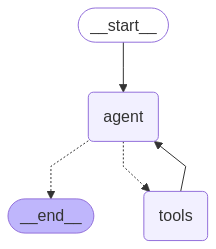

In [9]:
display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [10]:
# display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
config = {"configurable": {"thread_id": "def234555"}}

input_message = "si, consigliami un sito"

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

si, consigliami un sito
================================== Ai Message ==================================
Tool Calls:
  retrieve (470fcdec-b266-4b46-96eb-affac08f468b)
 Call ID: 470fcdec-b266-4b46-96eb-affac08f468b
  Args:
    query: siti di conoscenza per utenti italiani
================================= Tool Message =================================
Name: retrieve

Source: {'_id': 5, '_collection_name': 'FAQ'}
Content: 1. COME CONFIGUARE LE EMAIL E LA PEC
All’interno del portale è possibile configurare tutti gli indirizzi email e Pec dello
Studio  e  decidere,  a  seconda  delle  esigenze,  da  quale  indirizzo  inviare  la
corrispondenza.  
Dal menu principale cliccare su Configurazioni  Parametri Email 
Premere ora il simbolo 
  per inserire i parametri dell’email 
Compilare i campi della finestra :
- Descrizione  (inserire  il  riferimento  dell’email,  es:  Mario  oppure  Solleciti
oppure amministra